# 5.2 Visualize/Model

In this notebook, we use `dask`'s `DataFrame` to further process and analyse the output of `passim` ([GitHub repo](https://github.com/dasmiq/passim)), a an open source software to detect text reuse developed by David Smith (Northeastern University). 

The data we use here was produced by running a subset of the [Impresso](http://impresso-project.ch)'s newspaper corpus through `passim`. For furter information and context, see [this slide deck](https://infoscience.epfl.ch/record/255933/files/slides.pdf).

**NB**: this notebook won't work in binder as it requires input data that are stored in a private s3 repository.

In [1]:
import os
import dask
import pandas as pd
import numpy as np
from dask import dataframe as dd
from dask.distributed import Client
from impresso_commons.path.path_s3 import IMPRESSO_STORAGEOPT

In [10]:
dask.__version__

'1.1.5'

## Read in passim data

In [24]:
# client = cluster.make_dask_client()

In [27]:
client = Client('localhost:8686')

In [28]:
client

Client Scheduler: tcp://localhost:8686 Dashboard: http://localhost:41267/status,Cluster Workers: 48 Cores: 48 Memory: 144.00 GB


In [29]:
input_bucket = "s3://processed-canonical-data/text-reuse/"
path_to_data = "test/out.json/"
path_output = "test/clusters.json/"

In [81]:
df = dd.read_json(
    f"{os.path.join(input_bucket, path_to_data)}*.json", 
    storage_options=IMPRESSO_STORAGEOPT
).set_index('uid').persist()

In [31]:
df.head()

,begin,cc,cluster,date,end,gid,id,pages,series,size,text,title
uid,,,,,,,,,,,,
-9223360541113828267,168,True,352187320617,1968-02-24,955,2328324961100034523,GDL-1968-02-24-a-i0240,"[{'id': 'GDL-1968-02-24-a-p0020', 'seq': 20, '...",GDL,10,TV.\n18.45 Bulletin de nouvelles.\n18.50 Publi...,• Tél é ^tr e bon plaisir
-9223360541113828267,39,True,32,1968-02-24,2017,2328324961100034523,GDL-1968-02-24-a-i0240,"[{'id': 'GDL-1968-02-24-a-p0020', 'seq': 20, '...",GDL,80757,SAMEDI 24 FÉVRIER\nProgramme suisse\n14. 00-15...,• Tél é ^tr e bon plaisir
-9223360541113828267,2027,True,32,1968-02-24,4301,2328324961100034523,GDL-1968-02-24-a-i0240,"[{'id': 'GDL-1968-02-24-a-p0020', 'seq': 20, '...",GDL,80757,DIMANCHE 25 FÉVRIER\nProgramme suisse\n10.15 P...,• Tél é ^tr e bon plaisir
-9223360541113828267,3166,True,1228360652012,1968-02-24,3457,2328324961100034523,GDL-1968-02-24-a-i0240,"[{'id': 'GDL-1968-02-24-a-p0020', 'seq': 20, '...",GDL,3,"17.15 Kiri le Clown.\n17.25 Ramuntcho (1958), ...",• Tél é ^tr e bon plaisir
-9223360541113828267,2093,True,17179874715,1968-02-24,2223,2328324961100034523,GDL-1968-02-24-a-i0240,"[{'id': 'GDL-1968-02-24-a-p0020', 'seq': 20, '...",GDL,55,"11.00 Un'ora per voi, reprise.\n12.00 Table ou...",• Tél é ^tr e bon plaisir


In [33]:
n_rows, n_cols = df.shape

In [35]:
n_rows.compute()

1170211

In [36]:
clusters_df = df.groupby('cluster').agg({'date': ['min', 'max'], 'size': 'count'}).compute()

In [37]:
clusters_df.loc[:,'time_delta'] = clusters_df.date['max'] - clusters_df.date['min']

In [38]:
clusters_df.head()

date             size time_delta
               min        max count           
cluster                                       
0       1982-07-24 1982-07-24     2     0 days
1       1982-07-24 1988-11-22     2  2313 days
2       1972-02-17 1972-02-17     2     0 days
3       1972-02-17 1972-02-17     2     0 days
4       1972-02-17 1972-02-17     2     0 days

In [25]:
# that's a silly one, just count TR instances per cluster
df.groupby('cluster')['size'].count().compute()

cluster
32               80757
89                2649
267                 65
279                 53
283                 35
287                 34
532               3256
674                642
821                152
3301               243
4326                 2
4327                 2
4328                 2
4329                 2
4330                 2
4331                 2
8589936556          35
8589938473          32
8589938915           2
8589938943           2
8589938944           2
8589939157          45
8589939175          71
8589940471         302
17179869184          3
17179869786         25
17179871344          2
17179873216          2
17179873350         27
17179874715         55
                 ...  
1159641178619        2
1271310322041        2
17179873390          2
17179873391          2
17179875608          2
34359742823          2
42949675053          2
42949679694          2
94489286978          2
94489286979          2
94489289113          2
188978564943         2
231

In [26]:
# get the list of newspapers for which a cluster contains TR instances
np = df.groupby('cluster').apply(lambda r:",".join(sorted(r['series'].unique())), meta=('np', object)).compute().sort_index()

In [120]:
clusters_df.loc[:, 'newspapers'] = np

In [121]:
clusters_df.head()

date             size time_delta newspapers
               min        max count                      
cluster                                                  
0       1982-07-24 1982-07-24     2     0 days    GDL,IMP
1       1982-07-24 1988-11-22     2  2313 days    GDL,IMP
2       1972-02-17 1972-02-17     2     0 days    GDL,IMP
3       1972-02-17 1972-02-17     2     0 days    GDL,IMP
4       1972-02-17 1972-02-17     2     0 days    GDL,IMP

In [39]:
def mint_document_ids(row):
    
    ids = row['id']
    begins = row['begin']
    ends = row['end']
    
    return ",".join([
        "{}@{}:{}".format(doc_id, begin, end)
        for doc_id, begin, end in zip(ids, begins, ends)
    ])
    
    return 

In [40]:
doc_ids = df.groupby('cluster').apply(mint_document_ids, meta=('document_ids', object)).compute().sort_index()

In [41]:
clusters_df.loc[:, 'members'] = doc_ids

In [42]:
clusters_df.head()

date             size time_delta  \
               min        max count              
cluster                                          
0       1982-07-24 1982-07-24     2     0 days   
1       1982-07-24 1988-11-22     2  2313 days   
2       1972-02-17 1972-02-17     2     0 days   
3       1972-02-17 1972-02-17     2     0 days   
4       1972-02-17 1972-02-17     2     0 days   

                                                   members  
                                                            
cluster                                                     
0        IMP-1982-07-24-a-i0012@0:3756,GDL-1982-07-24-a...  
1        IMP-1982-07-24-a-i0012@3262:3452,GDL-1988-11-2...  
2        GDL-1972-02-17-a-i0078@86:1439,IMP-1972-02-17-...  
3        GDL-1972-02-17-a-i0078@2119:2795,IMP-1972-02-1...  
4        GDL-1972-02-17-a-i0078@1456:2030,IMP-1972-02-1...

In [43]:
import re
import numpy as np

def lexicaloverlap(row):
    texts = row['text']
    first = True
    intersection = list()
    
    longest_text_lenght = max([len(text) for text in texts])
    
    for text in texts:
        if(first):
            first = False
            intersection = re.sub('[().,;:!0-9"{}\][»«]','',text).lower().split()
        else:
            processing = re.sub('[().,;:!0-9"{}\][»«]','',text).lower().split()
            intersection = np.intersect1d(processing, intersection)
            
    overlap_pct = (len(intersection) * 100) / longest_text_lenght
    return overlap_pct

In [44]:
import re
import numpy as np

def lexicaloverlap_revised(row):
    texts = row['text']
    first = True
    intersection = list()
    
    longest_text_length = max([len(text) for text in texts])
    
    token_sets = [
        set(re.sub('[().,;:!0-9"{}\][»«]','',text).lower().split())
        for text in texts
    ]
    
    longest_text_length = max([len(ts) for ts in token_sets])
    intersection = set.intersection(*token_sets)
    overlap_pct = (len(intersection) * 100) / longest_text_length
    return overlap_pct

In [45]:
overlap = df.groupby('cluster').apply(lexicaloverlap, meta=('lexical_overlap', object)).compute().sort_index()

In [46]:
overlap2 = df.groupby('cluster').apply(lexicaloverlap_revised, meta=('lexical_overlap2', object)).compute().sort_index()

In [47]:
overlap2.median()

67.5

In [48]:
clusters_df.loc[:, 'lexical_overlap'] = overlap2

In [49]:
clusters_df.head()

date             size time_delta  \
               min        max count              
cluster                                          
0       1982-07-24 1982-07-24     2     0 days   
1       1982-07-24 1988-11-22     2  2313 days   
2       1972-02-17 1972-02-17     2     0 days   
3       1972-02-17 1972-02-17     2     0 days   
4       1972-02-17 1972-02-17     2     0 days   

                                                   members lexical_overlap  
                                                                            
cluster                                                                     
0        IMP-1982-07-24-a-i0012@0:3756,GDL-1982-07-24-a...       76.265823  
1        IMP-1982-07-24-a-i0012@3262:3452,GDL-1988-11-2...       64.285714  
2        GDL-1972-02-17-a-i0078@86:1439,IMP-1972-02-17-...       82.857143  
3        GDL-1972-02-17-a-i0078@2119:2795,IMP-1972-02-1...       82.142857  
4        GDL-1972-02-17-a-i0078@1456:2030,IMP-1972-02-1...       65.000000

In [138]:
size = df.groupby('cluster').apply(lambda x: x['size'], meta=('cluster_size', object)).compute().sort_index()

In [50]:
clusters_df.loc[:, 'cluster_size'] = clusters_df['size']['count']

In [52]:
clusters_df.head()

date             size time_delta  \
               min        max count              
cluster                                          
0       1982-07-24 1982-07-24     2     0 days   
1       1982-07-24 1988-11-22     2  2313 days   
2       1972-02-17 1972-02-17     2     0 days   
3       1972-02-17 1972-02-17     2     0 days   
4       1972-02-17 1972-02-17     2     0 days   

                                                   members lexical_overlap  \
                                                                             
cluster                                                                      
0        IMP-1982-07-24-a-i0012@0:3756,GDL-1982-07-24-a...       76.265823   
1        IMP-1982-07-24-a-i0012@3262:3452,GDL-1988-11-2...       64.285714   
2        GDL-1972-02-17-a-i0078@86:1439,IMP-1972-02-17-...       82.857143   
3        GDL-1972-02-17-a-i0078@2119:2795,IMP-1972-02-1...       82.142857   
4        GDL-1972-02-17-a-i0078@1456:2030,IMP-1972-02-1...       65.000000   

        cluster_size  
                      
cluster               
0                  2  
1                  2  
2                  2  
3                  2  
4                  2

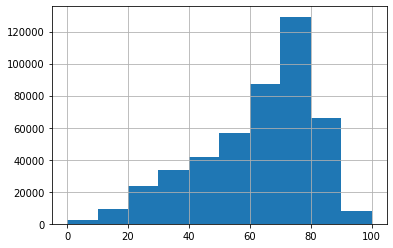

In [56]:
%matplotlib inline
clusters_df.lexical_overlap.hist()

In [65]:
clusters_df.cluster_size.describe()

count    458569.000000
mean          2.551876
std         119.640853
min           2.000000
25%           2.000000
50%           2.000000
75%           2.000000
max       80757.000000
Name: cluster_size, dtype: float64

In [79]:
clusters_df[clusters_df.cluster_size < 50000].describe()

,size,time_delta,lexical_overlap,cluster_size
,count,,,
count,458568.000000,458568,458568.000000,458568.000000
mean,2.375774,332 days 14:25:59.114460,62.386284,2.375774
std,9.640274,1945 days 12:16:05.903994,18.888465,9.640274
min,2.000000,0 days 00:00:00,0.000000,2.000000
25%,2.000000,0 days 00:00:00,50.000000,2.000000
50%,2.000000,0 days 00:00:00,67.500000,2.000000
75%,2.000000,3 days 00:00:00,76.666667,2.000000
max,3256.000000,61971 days 00:00:00,100.000000,3256.000000


In [71]:
clusters_df[clusters_df.cluster_size < 50000].count()

date             min      1
                 max      1
size             count    1
time_delta                1
members                   1
lexical_overlap           1
cluster_size              1
dtype: int64

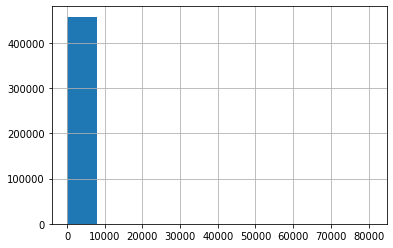

In [78]:
%matplotlib inline
clusters_df.cluster_size.hist()

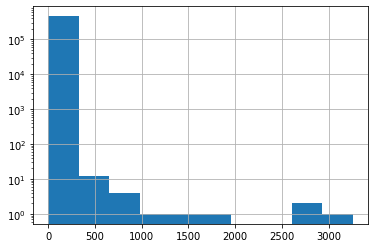

In [75]:
%matplotlib inline
clusters_df[clusters_df.cluster_size < 50000].cluster_size.hist(log=True)

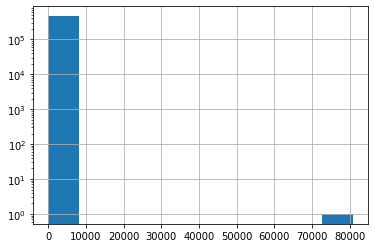

In [69]:
%matplotlib inline
clusters_df.cluster_size.hist(log=True)

## Write to s3 (JSON)

In [180]:
clusters_df.head()

date             size time_delta newspapers  \
               min        max count                         
cluster                                                     
0       1982-07-24 1982-07-24     2     0 days    GDL,IMP   
1       1982-07-24 1988-11-22     2  2313 days    GDL,IMP   
2       1972-02-17 1972-02-17     2     0 days    GDL,IMP   
3       1972-02-17 1972-02-17     2     0 days    GDL,IMP   
4       1972-02-17 1972-02-17     2     0 days    GDL,IMP   

                                                   members lexical_overlap  \
                                                                             
cluster                                                                      
0        IMP-1982-07-24-a-i0012@0:3756,GDL-1982-07-24-a...       76.265823   
1        IMP-1982-07-24-a-i0012@3262:3452,GDL-1988-11-2...       64.285714   
2        GDL-1972-02-17-a-i0078@86:1439,IMP-1972-02-17-...       82.857143   
3        GDL-1972-02-17-a-i0078@2119:2795,IMP-1972-02-1...       82.142857   
4        GDL-1972-02-17-a-i0078@1456:2030,IMP-1972-02-1...       65.000000   

        cluster_size  
                      
cluster               
0                  2  
1                  2  
2                  2  
3                  2  
4                  2

In [181]:
temp = clusters_df[["time_delta", "newspapers", "members", "lexical_overlap", "cluster_size"]].reset_index()

In [182]:
clusters_ddf = dd.from_pandas(temp, chunksize=1000)

In [184]:
clusters_ddf.index

Dask Index Structure:
npartitions=459
0         int64
1000        ...
          ...  
458000      ...
458568      ...
dtype: int64
Dask Name: from_pandas, 918 tasks

In [185]:
clusters_ddf.head()

,cluster,time_delta,newspapers,members,lexical_overlap,cluster_size
,,,,,,
0,0,0 days,"GDL,IMP","IMP-1982-07-24-a-i0012@0:3756,GDL-1982-07-24-a...",76.265823,2
1,1,2313 days,"GDL,IMP","IMP-1982-07-24-a-i0012@3262:3452,GDL-1988-11-2...",64.285714,2
2,2,0 days,"GDL,IMP","GDL-1972-02-17-a-i0078@86:1439,IMP-1972-02-17-...",82.857143,2
3,3,0 days,"GDL,IMP","GDL-1972-02-17-a-i0078@2119:2795,IMP-1972-02-1...",82.142857,2
4,4,0 days,"GDL,IMP","GDL-1972-02-17-a-i0078@1456:2030,IMP-1972-02-1...",65.000000,2


In [186]:
path_output = 'test/clusters.json/'

In [157]:
dd.read_json?

In [ ]:
# dask dataframes has a problem creating json output of a multi-index dataframe
# the json it creates it's not valid and cannot be read back into a dask dataframe
# so the format below is a workaround
output_files = dd.to_json(
    clusters_ddf.reset_index(),
    url_path=f"{os.path.join(input_bucket, path_output)}*.json", 
    orient='split',
    index=False,
    storage_options=IMPRESSO_STORAGEOPT
)

In [ ]:
output_files

In [188]:
test = db.read_text(
    f"{os.path.join(input_bucket, path_output)}*.json", 
    storage_options=IMPRESSO_STORAGEOPT
).map(read_json).compute()

In [100]:
def read_json(string):
    try:
        return json.loads(string)
    except Exception:
        pass

In [101]:
test = db.read_text(
    f"{os.path.join(input_bucket, path_output)}*.json", 
    storage_options=IMPRESSO_STORAGEOPT
).map(read_json).compute()

In [109]:
json.loads?

## Write output to s3 (CSV)

In [62]:
clusters_ddf = dd.from_pandas(clusters_df, chunksize=1000)

In [77]:
path_output = 'test/clusters'

In [ ]:
dd.to_csv(
    clusters_ddf,
    url_path=f"{os.path.join(input_bucket, path_output)}*.csv", 
    storage_options=IMPRESSO_STORAGEOPT
)

In [87]:
dd.to_json?

In [84]:
test_ddf = dd.read_csv(
    urlpath=f"{os.path.join(input_bucket, path_output)}-*.csv", 
    assume_missing=True,
    storage_options=IMPRESSO_STORAGEOPT
)

In [86]:
test_ddf.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 8 entries, Unnamed: 0 to lexical_overlap
dtypes: object(7), float64(1)